# I. Installation et importation des packages :

In [ ]:
!pip install pyDRMetrics

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from umap import UMAP
from pyDRMetrics.pyDRMetrics import *
from matplotlib.colors import ListedColormap
from matplotlib import cm


from joblib import Parallel, delayed
from sklearn import datasets,metrics
from tqdm import tqdm




In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


In [ ]:
def gen_agree_dist(D1: np.ndarray,
                   D2: np.ndarray,
                   start_k: int,
                   end_k: int,
                   prox_mode: str='dis',
                   sym_mode: str='sym') -> dict:
    """
    Calcule une métrique d'agrément entre deux configurations sur une plage de tailles de voisinage.

    Args:
        D1, D2: Matrices d'entrée représentant deux configurations. Ce pourraient être, par exemple,
            des matrices de distance ou de similarité décrivant les relations entre les éléments dans
            chaque configuration.
        start_k, end_k: La plage de tailles de voisinage pour lesquelles calculer la métrique d'agrément.
            k représente la taille du voisinage considéré lors du calcul de l'agrément entre les deux
            configurations.
        prox_mode: Détermine si les matrices d'entrée représentent des dissimilarités ('dis') ou des similarités
            ('sim'). Cela affecte la manière dont les matrices sont triées et traitées.
       sym_mode: Indique le mode de symétrie des matrices d'entrée - si elles doivent etre traitées comme
           symétriques ('sym'), symétriques par ligne ('row') ou symétriques par colonne ('col').

    Returns:
        Un dictionnaire contenant les résultats et les métadonnées du calcul de l'agrément.
    """
    # La fonction commence par déterminer le nombre d'éléments dans les matrices d'entrée et
    # symétrise les matrices si nécessaire.
    n_items = D1.shape[0]
    if sym_mode == 'sym':
        D1 = (D1 + D1.T) / 2
        D2 = (D2 + D2.T) / 2

    # Les matrices sont triées selon le `prox_mode` et `sym_mode` spécifiés.
    # Les indices triés sont stockés dans `IDX1` et `IDX2`.
    # Toute auto-référence dans les indices (oÃ¹ un élément serait son propre voisin) est supprimée.
    is_decreasing = prox_mode != 'dis'
    IDX1 = np.argsort(D1, axis=1 if sym_mode != 'col' else 0) + 1
    IDX2 = np.argsort(D2, axis=1 if sym_mode != 'col' else 0) + 1
    IDX1 = np.array([np.delete(row, np.where(row == i + 1)) for i, row in enumerate(IDX1)])
    IDX2 = np.array([np.delete(row, np.where(row == i + 1)) for i, row in enumerate(IDX2)])

    # Initialisation des tableaux pour contenir les résultats intermédiaires et finaux.
    nok = end_k - start_k + 1
    agr_values = np.zeros(nok)
    adj_num_values = np.zeros(nok)
    adj_denom_values = np.zeros(nok)
    er_agr_values = np.zeros(nok)
    row_total_agree = np.zeros((n_items, nok + 1))
    row_agree = np.zeros((n_items, nok + 1))
    total_agree = 0

    # Si `start_k` est supérieur à  1, la fonction calcule un score d'agrément préliminaire pour
    # les voisinages plus petits que `start_k`.
    if start_k > 1:
        for n in range(n_items):
            temp = np.intersect1d(IDX1[n, :start_k - 1], IDX2[n, :start_k - 1])
            row_total_agree[n, 0] = len(temp)
            row_agree[n, 0] = len(temp) / (start_k - 1)
            total_agree += (len(temp) / (start_k - 1))

    # Pour chaque valeur de k dans la plage [start_k, end_k], la fonction calcule l'agrément
    # pour cette taille de voisinage. Cela implique :
    ##### 1. De compter les voisins communs entre les deux configurations pour chaque élément.
    ##### 2. De mettre à  jour le total de l'agrément et les scores d'agrément spécifiques à  chaque ligne.
    for k in range(start_k, end_k + 1):
        for n in range(n_items):
            increment = np.sum(IDX1[n, k - 1] == IDX2[n, k - 1])
            increment += np.sum(IDX1[n, :k - 1] == IDX2[n, k - 1])
            increment += np.sum(IDX2[n, :k - 1] == IDX1[n, k - 1])
            total_agree += increment
            row_total_agree[n, k - start_k + 1] = row_total_agree[n, k - start_k] + increment
            row_agree[n, k - start_k + 1] = row_total_agree[n, k - start_k + 1] / k

        # Les valeurs d'agrément `agr_values` pour chaque `k` sont ensuite normalisées par le nombre
        # d'éléments et la taille du voisinage.
        agr_values[k - start_k] = total_agree / (n_items * k)

        # La fonction calcule les valeurs d'agrément attendues par hasard `er_agr_values` et utilise ces
        # dernières pour ajuster les scores d'agrément bruts, fournissant une métrique d'agrément ajustée
        # `adj_agree` qui tient compte de l'agrément par hasard.
        er_agr_values[k - start_k] = k / (n_items - 1)
        adj_num_values[k - start_k] = agr_values[k - start_k] - er_agr_values[k - start_k]
        adj_denom_values[k - start_k] = 1 - er_agr_values[k - start_k]

    # Calcul de l'agrément et de l'agrément ajusté.
    agree = np.mean(agr_values)
    adj_agree = np.sum(adj_num_values) / np.sum(adj_denom_values)

    # La fonction compile toutes les métriques calculées, ainsi que des informations supplémentaires sur
    # le calcul, dans un dictionnaire nommée `out_struct` et le retourne.
    out_struct = {
        'n': n_items,
        'Startk': start_k,
        'Endk': end_k,
        'Nok': nok,
        'RowTotalAgree': row_total_agree,
        'RowAgree': row_agree,
        'AgrValues': agr_values,
        'ER(Agr)': er_agr_values,
        'AdjNumValues': adj_num_values,
        'AdjDenomValues': adj_denom_values,
        'TotalAgree': total_agree,
        'Agree': agree, # Coefficient d'agrément.
        'AdjAgree': adj_agree, # Coefficient d'agrément ajustée.
    }

    return out_struct

from scipy.spatial import distance

def evaluate_reduction(embeddings_original,embeddings_reduced ):
    #Calculer les matrices de distances
    D1 = distance.squareform (distance.pdist (embeddings_original, 'euclidean'))
    D2 = distance.squareform (distance.pdist (embeddings_reduced, 'euclidean'))
    start_k = 20
    end_k= 30
    result = gen_agree_dist (D1, D2, start_k, end_k)
    print(f"Coefficient d'agrément brut: {result['Agree']}")
    print (f"Coefficient d'agrément ajusté: {result['AdjAgree']}")
    return result['AdjAgree']

# 1. Importation des données et leurs caractéristiques :

In [ ]:
# Chargement des données
pubmed_data_url="https://cifre.s3.eu-north-1.amazonaws.com/pubmed_dataset.pickle"
bbc_data_url="https://cifre.s3.eu-north-1.amazonaws.com/bbc_dataset.pickle"

pubmed_data=pd.read_pickle(pubmed_data_url)
bbc_data=pd.read_pickle(bbc_data_url)

# Extraction des textes et labels pour PubMed 20k RCT
pubmed_X = pubmed_data['embeddings']
pubmed_labels = pubmed_data['labels']

# Extraction des textes et labels pour BBC News
bbc_X = bbc_data['embeddings']
bbc_labels = bbc_data['labels']


In [ ]:
# Détermination de la dimension des données
num_documents_pubmed, num_features_pubmed = pubmed_X.shape
num_documents_bbc, num_features_bbc = bbc_X.shape

print('Informations sur les données PubMed et BBC : ')
print("PubMed 20k RCT:")
print(f"Dimension : {pubmed_X.shape}, Nombre de documents : {num_documents_pubmed}, Nombre de caractéristiques : {num_features_pubmed}")

print("BBC News:")
print(f"Dimension : {bbc_X.shape}, Nombre de documents : {num_documents_bbc}, Nombre de caractéristiques : {num_features_bbc}")

Informations sur les données PubMed et BBC : 
PubMed 20k RCT:
Dimension : (20000, 1536), Nombre de documents : 20000, Nombre de caractéristiques : 1536
BBC News:
Dimension : (2225, 1536), Nombre de documents : 2225, Nombre de caractéristiques : 1536


In [ ]:
# Fonction pour annoter la valeur maximale dans le plot
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    text = "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94, 0.96), **kw)

In [ ]:
def evaluate_clustering(X, labels_true, labels_pred):
    silhouette = silhouette_score(X, labels_pred)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    print(f"Silhouette Score : {silhouette}")
    print(f"NMI : {nmi}")
    return silhouette, nmi

In [ ]:
# Clustering sans réduction de dimension pour PubMed 20k RCT
kmeans_pubmed = KMeans(n_clusters=5, random_state=42)
kmeans_labels_pubmed = kmeans_pubmed.fit_predict(pubmed_X)
print("\nClustering sans réduction de dimension pour PubMed 20k RCT:")
silhouette_original_pubmed, nmi_original_pubmed = evaluate_clustering(pubmed_X,pubmed_labels, kmeans_labels_pubmed)

# Clustering sans réduction de dimension pour BBC News
kmeans_bbc = KMeans(n_clusters=5, random_state=42)
kmeans_labels_bbc = kmeans_bbc.fit_predict(bbc_X)
print("\nClustering sans réduction de dimension pour BBC News:")
silhouette_original_bbc, nmi_original_bbc = evaluate_clustering(bbc_X, bbc_labels, kmeans_labels_bbc)


Clustering sans réduction de dimension pour PubMed 20k RCT:
Silhouette Score (Original): 0.01698022920263104
NMI (Original): 0.20185827481666363

Clustering sans réduction de dimension pour BBC News:
Silhouette Score (Original): 0.058408734937559305
NMI (Original): 0.9117698299831813


# 2. ACP + k-means :

In [ ]:
# ACP suivie d'un K-means avec différents nombres de composantes principales
def pca_kmeans(X, n_components, n_clusters):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pred = kmeans.fit_predict(X_pca)

    return X_pca,labels_pred

## 2.1. Choix des paramètres optimaux :

In [ ]:
pca_components = [2, 3, 5, 10, 15, 20]
n_clusters= 5
silhouette_pubmed_scores=[]
nmi_pubmed_scores=[]
for pca_component in pca_components:
  print (f"ACP + k-means avec nombre de composantes = {pca_component} sur les données PubMed :")
  pubmed_pca,y_pred_pubmed=pca_kmeans(pubmed_X, pca_component, n_clusters)
  silhouette_pubmed, nmi_pubmed=evaluate_clustering(pubmed_pca,pubmed_labels,y_pred_pubmed)
  silhouette_pubmed_scores.append(silhouette_pubmed)
  nmi_pubmed_scores.append(nmi_pubmed)


silhouette_bbc_scores=[]
nmi_bbc_scores=[]
for pca_component in pca_components:
  print (f"ACP + k-means avec nombre de composantes = {pca_component} sur les données BBC :")
  bbc_pca,y_pred_bbc=pca_kmeans(bbc_X, pca_component, n_clusters)
  silhouette_bbc, nmi_bbc=evaluate_clustering(bbc_pca,bbc_labels,y_pred_bbc)
  silhouette_bbc_scores.append(silhouette_bbc)
  nmi_bbc_scores.append(nmi_bbc)

ACP + k-means avec nombre de composantes = 2 sur les données PubMed :
Silhouette Score : 0.3447454365052122
NMI : 0.19609658946773137
ACP + k-means avec nombre de composantes = 3 sur les données PubMed :
Silhouette Score : 0.2686230557861825
NMI : 0.2194726453737412
ACP + k-means avec nombre de composantes = 5 sur les données PubMed :
Silhouette Score : 0.19509312157322622
NMI : 0.19820373688807275
ACP + k-means avec nombre de composantes = 10 sur les données PubMed :
Silhouette Score : 0.11942323975870185
NMI : 0.20358937556105547
ACP + k-means avec nombre de composantes = 15 sur les données PubMed :
Silhouette Score : 0.09536769509034475
NMI : 0.20142068601569624
ACP + k-means avec nombre de composantes = 20 sur les données PubMed :
Silhouette Score : 0.08177302018118393
NMI : 0.2029439224670587
ACP + k-means avec nombre de composantes = 2 sur les données BBC :
Silhouette Score : 0.4253064825452751
NMI : 0.6656299647868276
ACP + k-means avec nombre de composantes = 3 sur les données 

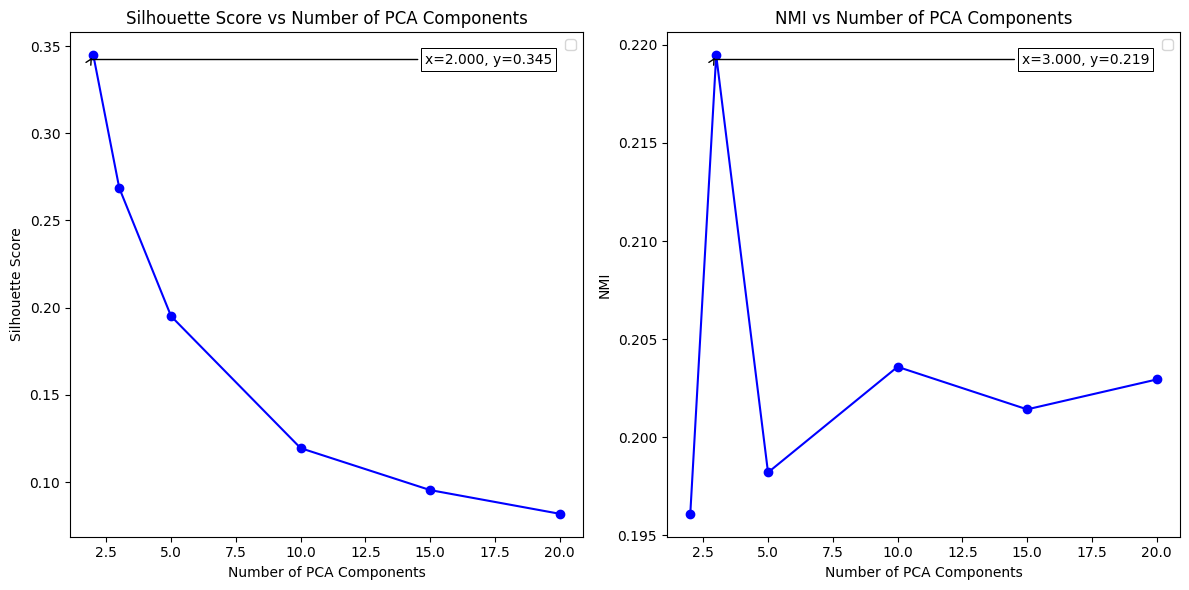

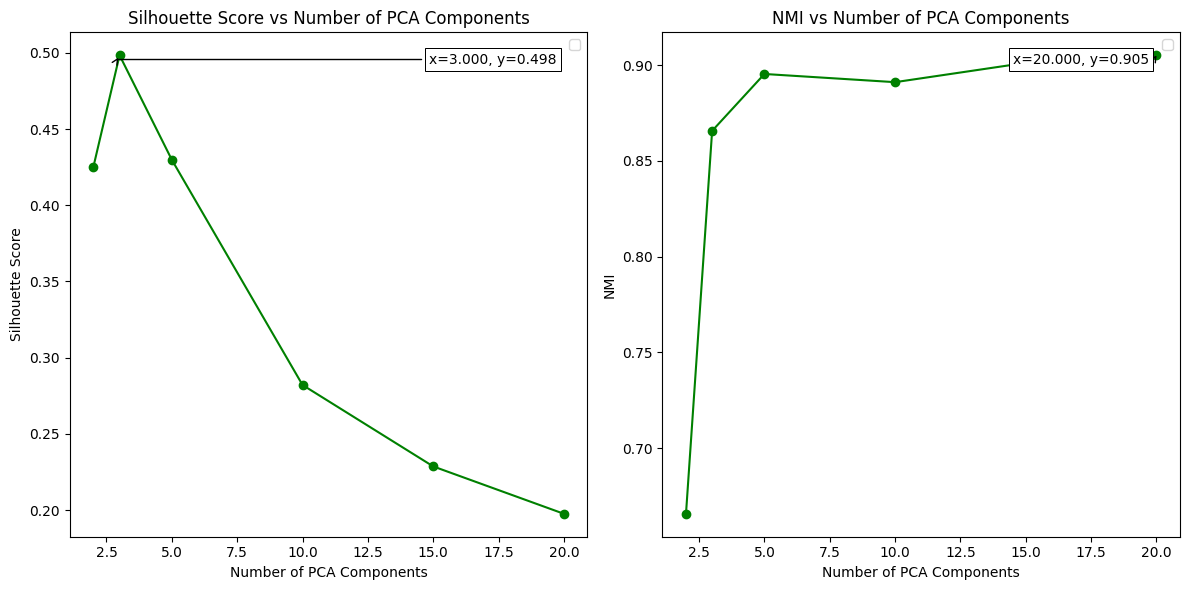

In [ ]:

max_silhouette_pubmed_idx = np.argmax(silhouette_pubmed_scores)
max_nmi_pubmed_idx = np.argmax(nmi_pubmed_scores)

# Find the indices of maximum values for BBC
max_silhouette_bbc_idx = np.argmax(silhouette_bbc_scores)
max_nmi_bbc_idx = np.argmax(nmi_bbc_scores)

# Plotting
plt.figure(figsize=(12, 6))

# Subplot for PubMed - Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(pca_components, silhouette_pubmed_scores, marker='o', color='blue')
plt.title('Silhouette Score vs Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
annot_max(pca_components, silhouette_pubmed_scores)
plt.legend()

# Subplot for PubMed - NMI
plt.subplot(1, 2, 2)
plt.plot(pca_components, nmi_pubmed_scores, marker='o', color='blue')
plt.title('NMI vs Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('NMI')
annot_max(pca_components, nmi_pubmed_scores)
plt.legend()

plt.tight_layout()
plt.show()

# Plotting for BBC
plt.figure(figsize=(12, 6))

# Subplot for BBC - Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(pca_components, silhouette_bbc_scores, marker='o', color='green')
plt.title('Silhouette Score vs Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
annot_max(pca_components, silhouette_bbc_scores)
plt.legend()

# Subplot for BBC - NMI
plt.subplot(1, 2, 2)
plt.plot(pca_components, nmi_bbc_scores, marker='o', color='green')
plt.title('NMI vs Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('NMI')
annot_max(pca_components, nmi_bbc_scores)
plt.legend()

plt.tight_layout()
plt.show()



Selon les scores de NMI et Silhouette, nous esayons de trouver un compromis pour choisir le nombre de composantes qui donne les meilleures performances. Sur PubMed, quan dle silhouette score est à son max, le NMI est très médiocre et vice versa. Par contre quand le nombre de composante = 5, on trouve un bon compromis entre NMI, et silhouette score. Sur BBC, au meilleur silhouette score, le NMI est assez bon (Nombre de composante = 3) et au meilleur NMI, le silhouette score est médiocre (Nombre de composante = 20) Donc nous choisissons le nombre de composantes = 3.


> Conclusion :
*   Sur les données PubMed 20k RCT :
Nombre de composantes = 3.
*   Sur les données BBC News :
Nombre de composantes = 5






## 2.2. Visualisation des résultats :

Silhouette Score : 0.26864021217323714
NMI : 0.2194561243031375
Silhouette Score : 0.49844866669046006
NMI : 0.8657426487963162


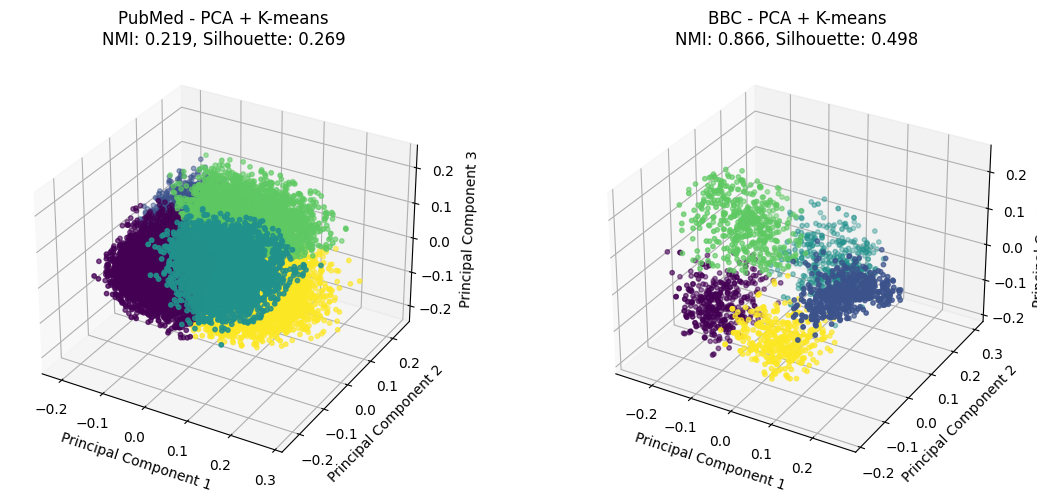

In [ ]:
pubmed_X_pca, y_pred_pubmed=pca_kmeans(pubmed_X, 3, 5)

bbc_X_pca, y_pred_bb= pca_kmeans(bbc_X, 3, 5)

from mpl_toolkits.mplot3d import Axes3D  # For 3D scatter plots

# Function to plot 3D scatter plot with NMI and Silhouette in the title
def plot_3d_scatter(X_pca, y_pred, nmi, silhouette, title, ax):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_pred, cmap='viridis', s=10)
    ax.set_title(f'{title}\nNMI: {nmi:.3f}, Silhouette: {silhouette:.3f}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

# Compute NMI and Silhouette for PubMed
silhouette_pubmed, nmi_pubmed = evaluate_clustering(pubmed_X_pca, pubmed_labels, y_pred_pubmed)

# Compute NMI and Silhouette for BBC
silhouette_bbc, nmi_bbc = evaluate_clustering(bbc_X_pca, bbc_labels, y_pred_bb)

# Plotting side by side
fig = plt.figure(figsize=(12, 5))

# Subplot for PubMed
ax1 = fig.add_subplot(121, projection='3d')
plot_3d_scatter(pubmed_X_pca, y_pred_pubmed, nmi_pubmed, silhouette_pubmed, 'PubMed - PCA + K-means', ax1)

# Subplot for BBC
ax2 = fig.add_subplot(122, projection='3d')
plot_3d_scatter(bbc_X_pca, y_pred_bb, nmi_bbc, silhouette_bbc, 'BBC - PCA + K-means', ax2)

plt.tight_layout()
plt.show()


## 2.3. Comparaison avec k-means sans réduction :

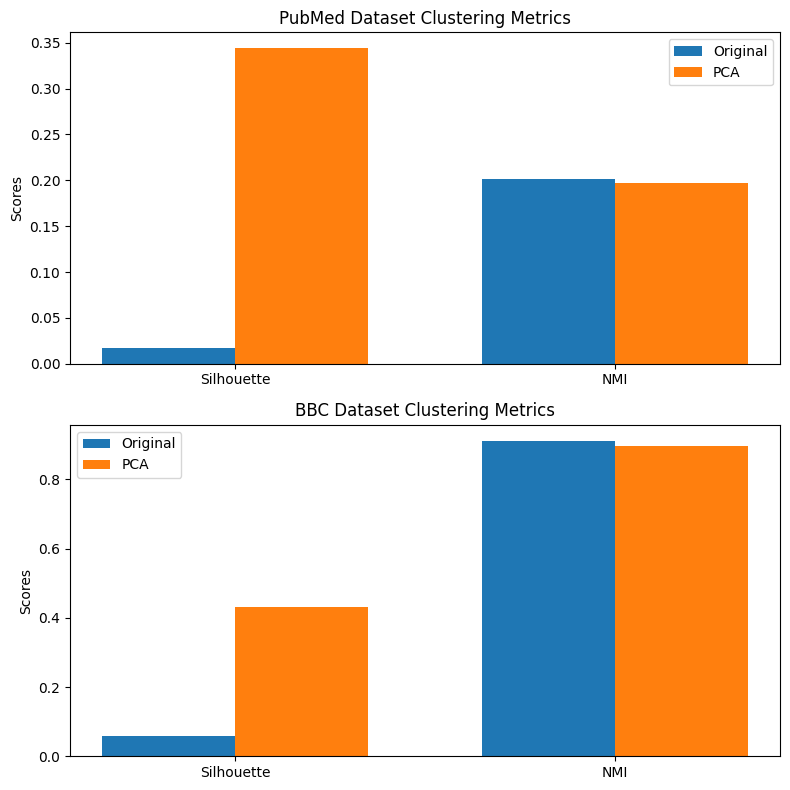

In [ ]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
# PubMed
ax[0].bar(x - width/2, pubmed_metrics, width, label='Original')
ax[0].bar(x + width/2, pubmed_metrics_pca, width, label='PCA')
ax[0].set_ylabel('Scores')
ax[0].set_title('PubMed Dataset Clustering Metrics')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

# BBC
ax[1].bar(x - width/2, bbc_metrics, width, label='Original')
ax[1].bar(x + width/2, bbc_metrics_pca, width, label='PCA')
ax[1].set_ylabel('Scores')
ax[1].set_title('BBC Dataset Clustering Metrics')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.tight_layout()
plt.show()

Interprétation :  
En comparant avec les résultats du k-means sans réduction de dimension, nous arrivons à voir que l'ACP a gardé quasiement les mêmes performances du k-means,  quoiqu'il a donné sur BBC un NMI (0.21) inférieur à l'original (0.20), avec une légère perte de données. Donc, les paramètres choisi pour chaque dataset sont les meilleurs.

> ***Conclusion : Nous pouvons voir que la méthode de réduction ACP conserve bien l'information sur les dataset PubMed et BBC.***



In [ ]:
X=pubmed_X
X_reduced, _ =pca_kmeans(pubmed_X, 3, 5)
drm=DRMetrics(X,X_reduced, None )
drm.report()



---


# 3. t-SNE + k-means :

In [ ]:
# Appliquer TSNE pour la réduction de dimension
def tsne_kmeans(X, perplexity, n_clusters):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pred = kmeans.fit_predict(X_tsne)

    return X_tsne, labels_pred

In [ ]:
import logging

# Configure the logging settings (you may customize these based on your needs)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


## 3.1. Choix des paramètres sur PubMed :

Silhouette Score : 0.3315161168575287
NMI : 0.027983199940692195
Silhouette Score : 0.3385888338088989
NMI : 0.03749945417747319
Silhouette Score : 0.35165244340896606
NMI : 0.11264162269427258
Silhouette Score : 0.36253681778907776
NMI : 0.13339076524275081
Silhouette Score : 0.3458770215511322
NMI : 0.07230091535054771
Silhouette Score : 0.36063891649246216
NMI : 0.1155277377807353


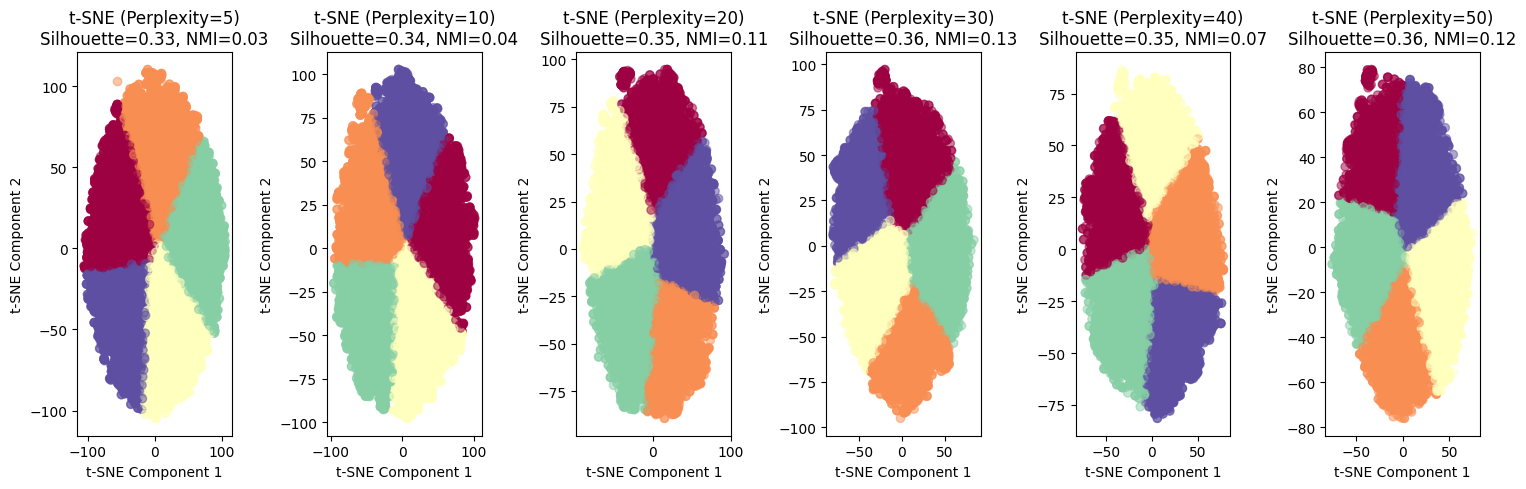

In [ ]:
from sklearn.manifold import TSNE
n_clusters= 5

# Appliquer t-SNE avec différentes valeurs de perplexité
perplexities = [5, 10, 20, 30, 40, 50]

# Définir le nombre de colonnes pour les sous-graphiques
num_cols = len(perplexities)

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))

# Effectuer t-SNE et le clustering pour chaque perplexité
for i, perplexity in enumerate(perplexities):
    # Créer un modèle t-SNE
    X_pubmed_tsne, y_pred_pubmed=tsne_kmeans(pubmed_X, perplexity, n_clusters)

    # Évaluer le clustering avec des métriques telles que le score de silhouette et la NMI
    silhouette_pubmed_tsne, nmi_pubmed_tsne=evaluate_clustering(X_pubmed_tsne,pubmed_labels,y_pred_pubmed)

    # Visualiser les résultats dans le sous-graphique correspondant
    axes[i].scatter(X_pubmed_tsne[:, 0], X_pubmed_tsne[:, 1], c=y_pred_pubmed, cmap='Spectral', alpha=0.5)
    axes[i].set_title(f't-SNE (Perplexity={perplexity})\nSilhouette={silhouette_pubmed_tsne:.2f}, NMI={nmi_pubmed_tsne:.2f}')
    axes[i].set_xlabel('t-SNE Component 1')
    axes[i].set_ylabel('t-SNE Component 2')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


## 3.2. Choix des paramètres sur BBC :

Silhouette Score : 0.3761029541492462
NMI : 0.7081805037138196
Silhouette Score : 0.4117073118686676
NMI : 0.755418180031313
Silhouette Score : 0.4456969201564789
NMI : 0.7925848264175899
Silhouette Score : 0.46663233637809753
NMI : 0.7978108379179666
Silhouette Score : 0.47440439462661743
NMI : 0.8181994721989155
Silhouette Score : 0.4893111288547516
NMI : 0.885354444338747


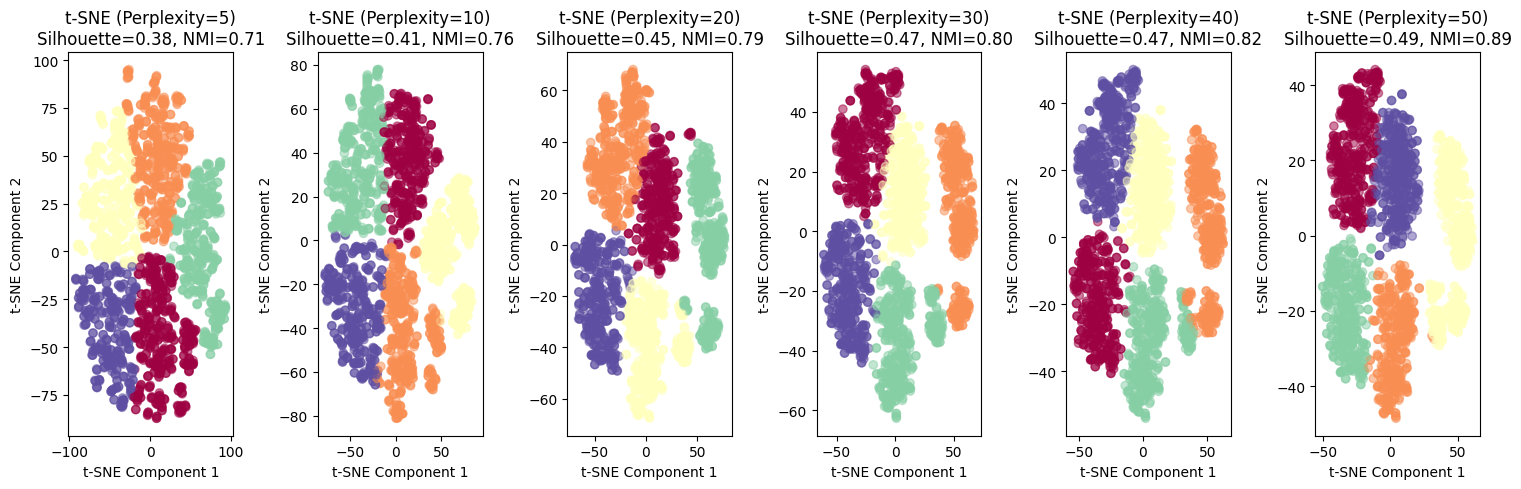

In [ ]:
n_clusters = 5

# Appliquer t-SNE avec différentes valeurs de perplexité
perplexities = [5, 10, 20, 30, 40, 50]

# Définir le nombre de colonnes pour les sous-graphiques
num_cols = len(perplexities)

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))

# Effectuer t-SNE et le clustering pour chaque perplexité
for i, perplexity in enumerate(perplexities):
    # Créer un modèle t-SNE
    X_bbc_tsne, y_pred_bbc = tsne_kmeans(bbc_X, perplexity, n_clusters)

    # Évaluer le clustering avec des métriques telles que le score de silhouette et la NMI
    silhouette_bbc_tsne, nmi_bbc_tsne = evaluate_clustering(X_bbc_tsne, bbc_labels, y_pred_bbc)

    # Visualiser les résultats dans le sous-graphique correspondant
    axes[i].scatter(X_bbc_tsne[:, 0], X_bbc_tsne[:, 1], c=y_pred_bbc, cmap='Spectral', alpha=0.5)
    axes[i].set_title(f't-SNE (Perplexity={perplexity})\nSilhouette={silhouette_bbc_tsne:.2f}, NMI={nmi_bbc_tsne:.2f}')
    axes[i].set_xlabel('t-SNE Component 1')
    axes[i].set_ylabel('t-SNE Component 2')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()




**Interprétation :**

*Sur les données PubMed :* Nous remarquons que le meilleur paramètre de perplexité est 50, il donne des scores NMI et Silhouette supérieure aux autres exécutions. Malgré ça, le NMI reste faible (0.12), et nous arrivons à voir ça avec la visualisation ci-dessus, où les clusters ne sont pas bien séparés.

Ceci est peut être dû au fait que les données PubMed sont riches en variable et ne peuvent être réduite à un espace de dimension très faible telle que 2 ou 3.

*Sur les données BBC :* Nous confirmons celà encore plus avec les données BBC, dont la dimension originale est nettement inférieure à celle de PubMed.  Ils ont obtenu de  bons résultats (NMI = 0.12, Silhoute = 0.49) et une bonne séparabilité des clusters.




## 3.3. Comparaison avec k-means sans réduction

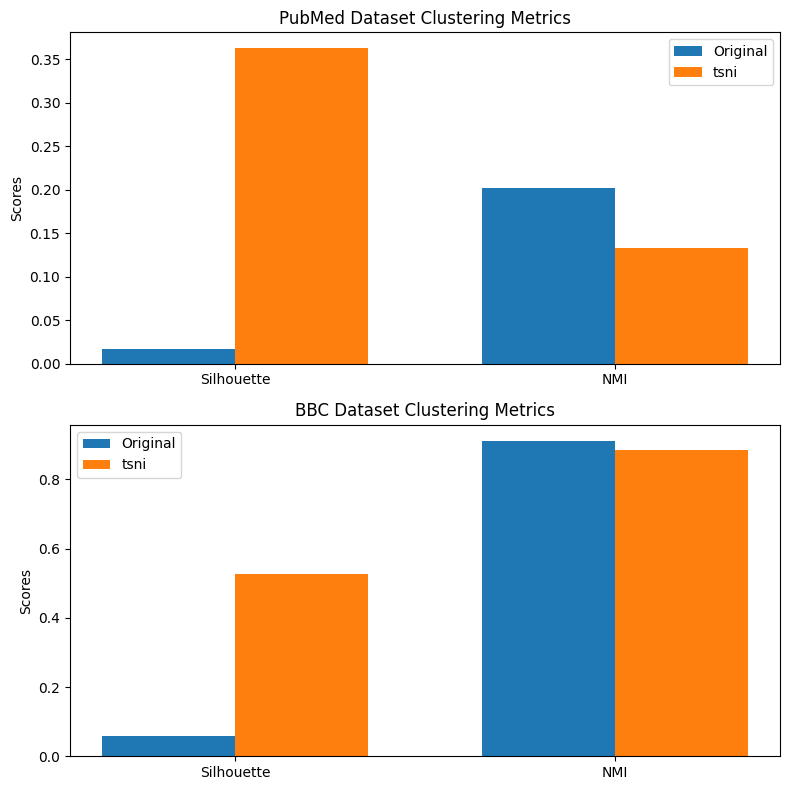

In [ ]:

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
# PubMed
ax[0].bar(x - width/2, pubmed_metrics, width, label='Original')
ax[0].bar(x + width/2, pubmed_metrics_tsni, width, label='tsni')
ax[0].set_ylabel('Scores')
ax[0].set_title('PubMed Dataset Clustering Metrics')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

# BBC
ax[1].bar(x - width/2, bbc_metrics, width, label='Original')
ax[1].bar(x + width/2, bbc_metrics_tsni, width, label='tsni')
ax[1].set_ylabel('Scores')
ax[1].set_title('BBC Dataset Clustering Metrics')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.tight_layout()
plt.show()

Nous remarquons une diminution de performances avec t-SNE par rapport au clustering sans réduction de dimension.


> Conclusion : t-SNE n'est pas la méthode de réduction la mieux adaptée aux données PubMed et BBC.





---


# 4. UMAP + k-means :
## 4.1. Choix des paramètres :
Quant à UMAP, plusieurs hyper-paramètres entrent en jeu :


*   Le nombre de voisins (*n_neighbors*) : varie de 30 à 50.
*   La distance minimale (*min_dist*) : ses meilleures valeurs varient de 0.005 à 0.5.
*   La mesure de similarité (*metric*) : Pour des vecteurs, nous choisissons entre la cosine similarity et la distance euclidéenne.

Nous essayons toutes ces combinaisons à l'aide du Parameter Grid, en parallélisant les calculs sur 4 jobs. Nous prenons les combinaisons qui donnent les meilleurs résultats.

In [ ]:
# Employer UMAP sur vos jeux de données
def umap_kmeans_nmi(X, n_components, g, n_clusters, labels_true):
    umap_model = UMAP(n_components=n_components, n_neighbors=g['n_neighbors'], min_dist=g['min_dist'], metric=g['metric'])
    X_umap = umap_model.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pred = kmeans.fit_predict(X_umap)

    nmi=normalized_mutual_info_score(labels_true, labels_pred)
    return nmi, g

# Employer UMAP sur vos jeux de données
def umap_kmeans(X, n_components, g, n_clusters, labels_true):
    umap_model = UMAP(n_components=n_components, n_neighbors=g['n_neighbors'], min_dist=g['min_dist'], metric=g['metric'])
    X_umap = umap_model.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pred = kmeans.fit_predict(X_umap)

    silhouette,nmi=evaluate_clustering(X_umap,labels_true, labels_pred)
    return X_umap, labels_pred, silhouette,nmi

In [ ]:
import time
from sklearn.model_selection import ParameterGrid

def dimension_reduce(n_components, X, y, n_clusters):
    param_grid = [{
        "n_neighbors": [20, 30, 40, 50],
        "min_dist": [0.1, 0.2, 0.3, 0.4, 0.5],
        "metric": ['cosine','euclidean']
    }]

    param_grid = ParameterGrid(param_grid)

    best_param=[]
    for n_component in n_components:
        results_pubmed = np.array(Parallel(n_jobs=8)(delayed(umap_kmeans_nmi)(X, n_component, g, n_clusters, y) for g in tqdm(param_grid)))
        param_sorted = sorted(results_pubmed, key=lambda t: t[0], reverse=True)[:1]
        best_param.append(param_sorted[0][1])
    return best_param

n_clusters=5
n_components=[2,3]
start_time = time.time()
best_param_pubmed=dimension_reduce(n_components,pubmed_X, pubmed_labels, n_clusters)
best_param_bbc=dimension_reduce(n_components,bbc_X, bbc_labels, n_clusters)

# Enregistrez le temps de fin
end_time = time.time()

# Calculez le temps écoulé
elapsed_time = end_time - start_time

# Affichez le temps écoulé
print(f"Temps d'exécution : {elapsed_time} secondes")



100%|██████████| 2/2 [00:00<00:00, 236.43it/s]
2024-02-09 11:50:43.911529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 11:50:43.912224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 11:50:43.916021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 11:50:44.060976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 11:50:44.061280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to regist

Temps d'exécution : 2077.3037362098694 secondes


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print(f"Meilleure combinaison d'hyper-paramètres d'UMAP pour PubMed :")
print(f"Nombre de composantes = 2, {best_param_pubmed[0]}")
print(f"Nombre de composantes = 3, {best_param_pubmed[1]}")
print("\n")

print(f"Meilleure combinaison d'hyper-paramètres d'UMAP pour BBC :")
print(f"Nombre de composantes = 2, {best_param_bbc[0]}")
print(f"Nombre de composantes = 3, {best_param_bbc[1]}")
print("\n")
print(f"Temps d'exécution : {elapsed_time} secondes")


Meilleure combinaison d'hyper-paramètres d'UMAP pour PubMed :
Nombre de composantes = 2, {'metric': 'cosine', 'min_dist': 0.1, 'n_neighbors': 40}
Nombre de composantes = 3, {'metric': 'euclidean', 'min_dist': 0.5, 'n_neighbors': 30}


Meilleure combinaison d'hyper-paramètres d'UMAP pour BBC :
Nombre de composantes = 2, {'metric': 'euclidean', 'min_dist': 0.3, 'n_neighbors': 30}
Nombre de composantes = 3, {'metric': 'cosine', 'min_dist': 0.4, 'n_neighbors': 30}


Temps d'exécution : 2077.3037362098694 secondes


## 4.2. Visualisation des résultats :

Silhouette Score : 0.35972777009010315
NMI : 0.06530048268840366
Silhouette Score : 0.2695956528186798
NMI : 0.08940163089252653


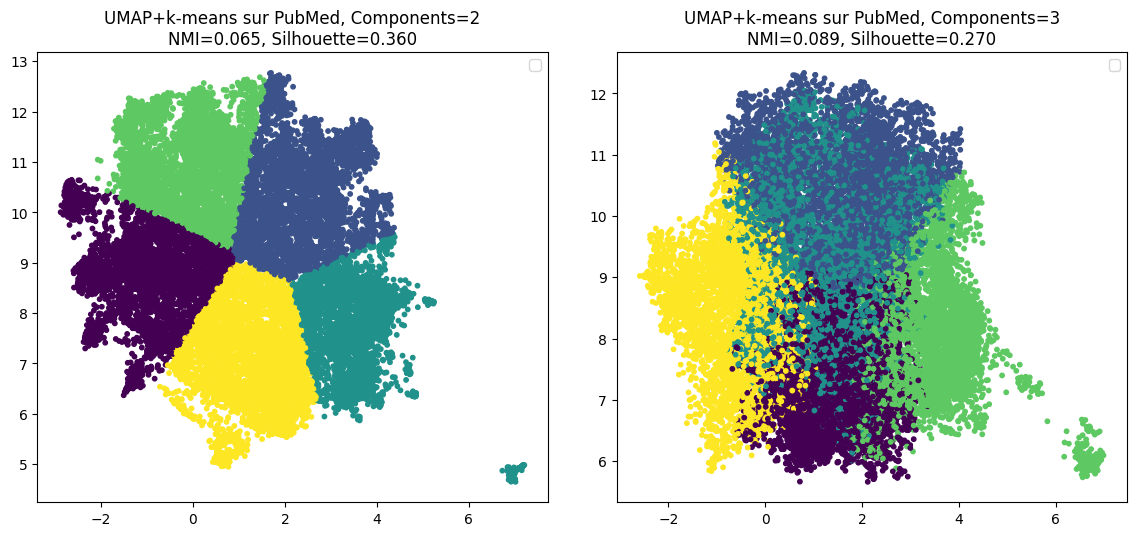

Silhouette Score : 0.5704496502876282
NMI : 0.9006360183781527
Silhouette Score : 0.5472312569618225
NMI : 0.894687757385394


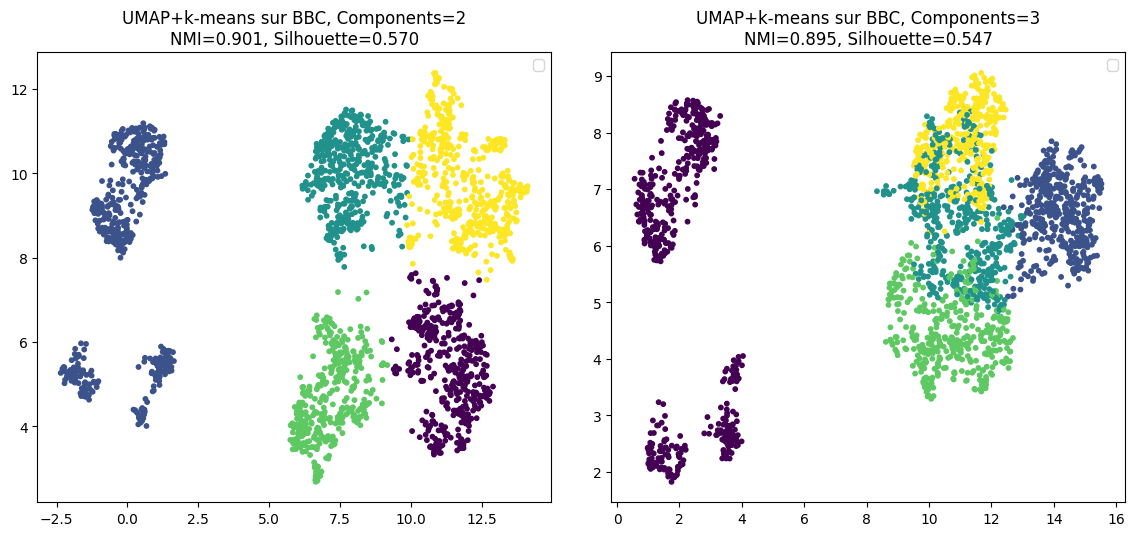

In [ ]:
# Subplot for PubMed
plt.figure(figsize=(12, 6))
for i in range(2):
    X_umap_pubmed, y_pred_pubmed, silhouette_pubmed, nmi_pubmed = umap_kmeans(pubmed_X, n_components[i], best_param_pubmed[i], n_clusters, pubmed_labels)
    plt.subplot(1, 2, i+1)
    plt.scatter(X_umap_pubmed[:, 0], X_umap_pubmed[:, 1], c=y_pred_pubmed, cmap='viridis', s=10)
    plt.title(f'UMAP+k-means sur PubMed, Components={n_components[i]}\nNMI={nmi_pubmed:.3f}, Silhouette={silhouette_pubmed:.3f}')
    plt.legend()

plt.tight_layout(pad=3.0)  # Add spacing between subplots and titles
plt.show()

# Plotting for BBC
plt.figure(figsize=(12, 6))
# Subplot for PubMed
for i in range(2):
    X_umap_bbc, y_pred_bbc, silhouette_bbc, nmi_bbc=umap_kmeans(bbc_X, n_components[i], best_param_bbc[i], n_clusters, bbc_labels)
    plt.subplot(1, 2, i+1)
    plt.scatter(X_umap_bbc[:, 0], X_umap_bbc[:, 1], c=y_pred_bbc, cmap='viridis', s=10)
    plt.title(f'UMAP+k-means sur BBC, Components={n_components[i]}\nNMI={nmi_bbc:.3f}, Silhouette={silhouette_bbc:.3f}')
    plt.legend()

plt.tight_layout(pad=3.0)  # Add spacing between subplots and titles
plt.show()


Interprétation :     
*Sur les données PubMed :* la méthode UMAP +k-means donne des résultats médiocre, ce qui est peut être dû au nobre d ecomposantes qui ne suffit pas pour capturer les relations entre les données originales sur l'espace de dimension réduite. Comme perspectives, nous pouvons essayer d'autres composantes plus grandes telles que 16, 32 ou 64.

*Sur les données BBC :* UMAP à 2 composantes (et même 3)  est très bien adapté aux données BBC et donne de don résultats ent ermes de score NMI et silhouette.

## 4.3. Comparaiosn avec le k-means sans réduction de dimension :     



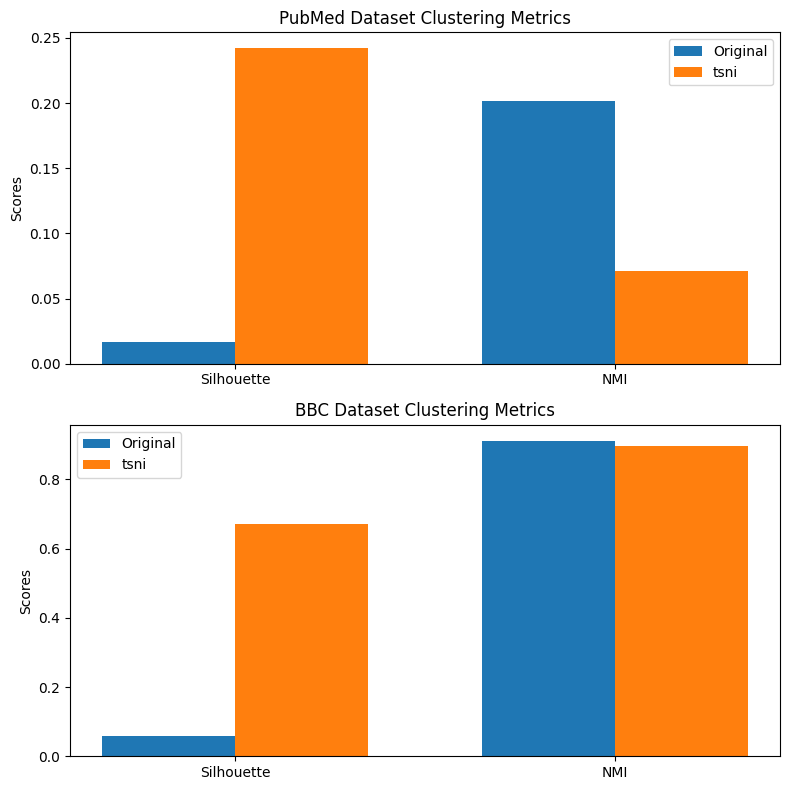

In [ ]:

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
# PubMed
ax[0].bar(x - width/2, pubmed_metrics, width, label='Original')
ax[0].bar(x + width/2, pubmed_metrics_umap, width, label='tsni')
ax[0].set_ylabel('Scores')
ax[0].set_title('PubMed Dataset Clustering Metrics')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

# BBC
ax[1].bar(x - width/2, bbc_metrics, width, label='Original')
ax[1].bar(x + width/2, bbc_metrics_umap, width, label='tsni')
ax[1].set_ylabel('Scores')
ax[1].set_title('BBC Dataset Clustering Metrics')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.tight_layout()
plt.show()


Avec une diminution des performances sur les donnés PubMed, nous pouvons dire qu'il y a une grosse perte d'informations avec UMAP(n_components=2,3). Par contre, sur BBC, l'UMAP donne des résultats quasi-similaires au k-means sans réduciton de dimension.


> UMAP à deux composantes est très bien adapté aux données BBC et garde l'information.




---


# 5. pyDRMetrics :
## 5.1. Sur PubMed
### 5.1.1. ACP + k-means :

PCA DRmetrics repport
--- Sample Reconstruction (X and Xr) ---
left column: original waveform		 right column: recovered waveform


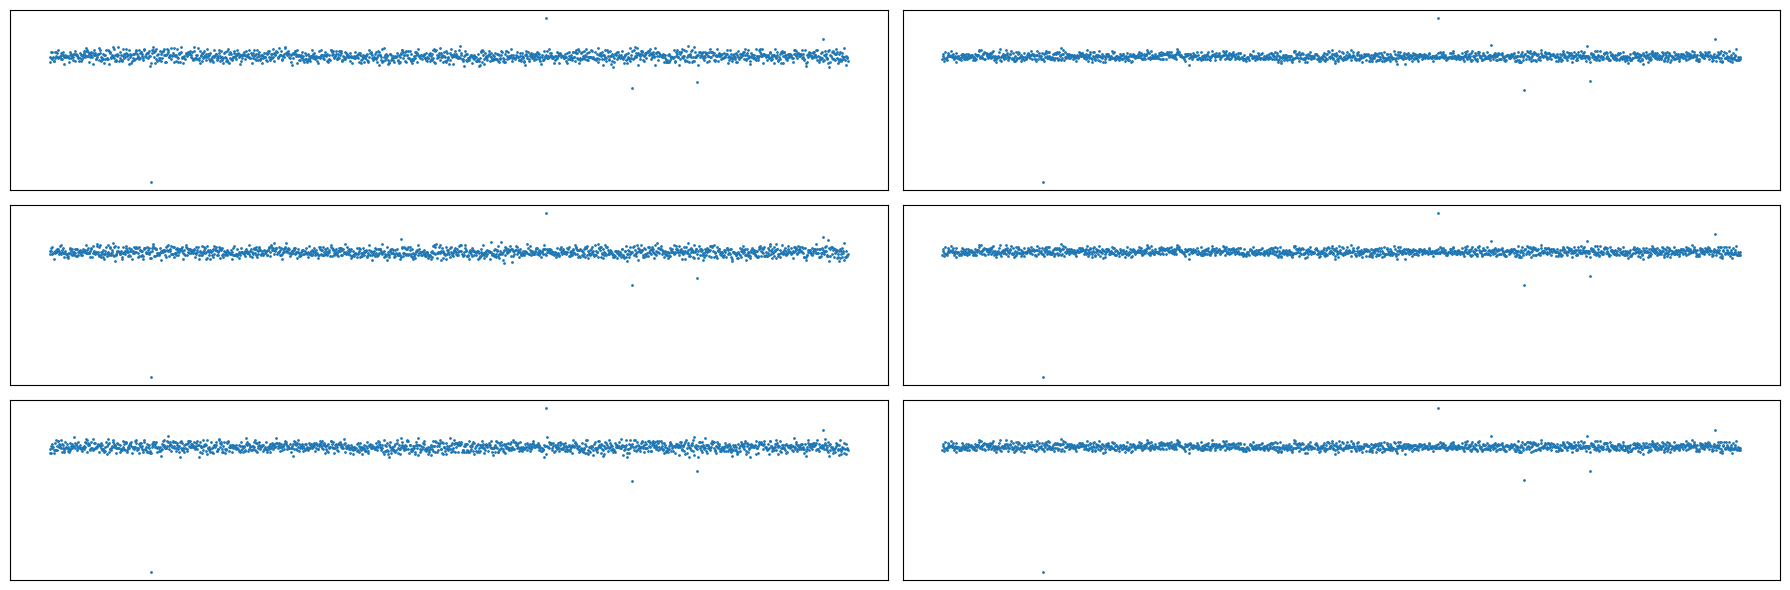

rMSE =  0.21280928877530175
--- Distance Matrices (D and Dz) ---


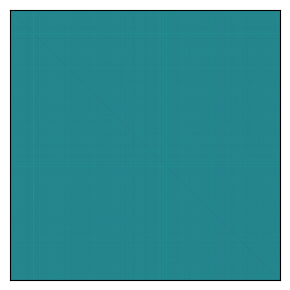

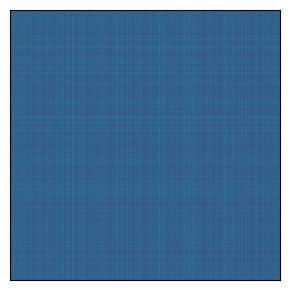

Residual Variance (using Pearson's r) =  0.8842564932293341
Residual Variance (using Spearman's r) =  0.8625958445707752
--- Ranking Matrices (R and Rz) ---


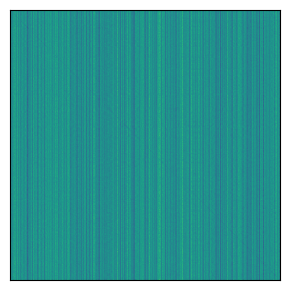

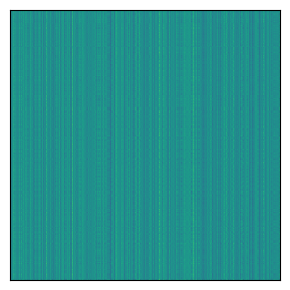

--- Co-ranking Matrix (Q) ---


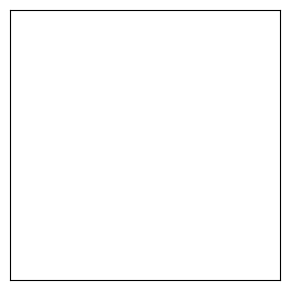

--- Trustworthiness T(k) and Continuity C(k) ---


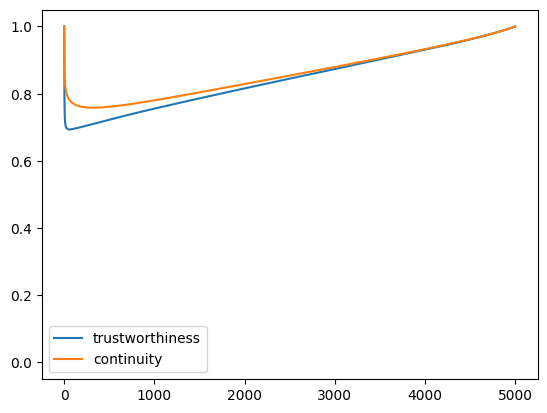

AUC of T =  0.8437818359683602
AUC of C =  0.8591327721179658
--- QNN(k) Curve ---


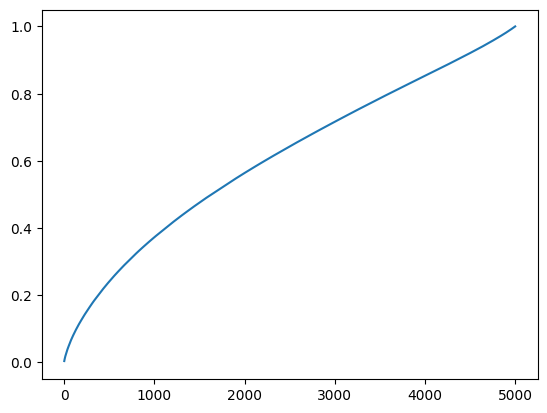

AUC of QNN =  0.610295383702514
--- LCMC(k) Curve ---


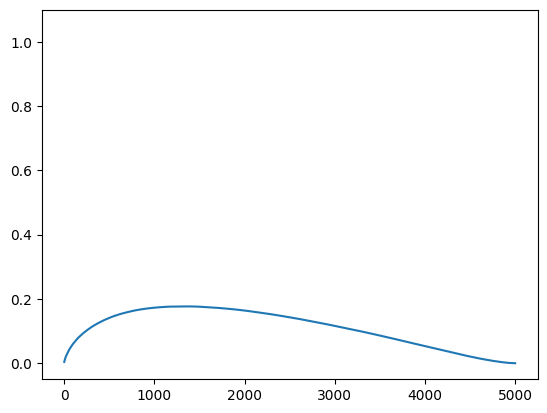

kmax (0-based index) =  1314
Qlocal =  0.2705624636692927
Qglobal =  0.7314106344891746


In [ ]:
X=pubmed_X
X_reduced, _ =pca_kmeans(pubmed_X, 3, 5)
drm=DRMetrics(X,X_reduced, None )
print("PCA DRmetrics repport")
drm.report()

**Interprétation :**
L'analyse du rapport sur la réduction de dimensionnalité par l'Analyse en Composantes Principales (PCA) révèle plusieurs points clés concernant la performance de cette technique. Premièrement, la PCA a été capable de capturer la structure principale des données, comme le montre la similitude entre les formes d'onde originales et reconstruites, bien qu'une perte de détail soit observée, ce qui est attendu avec la réduction de dimensionnalité. Les matrices de distance montrent que les relations de distance entre les points sont généralement préservées dans l'espace réduit. La variance résiduelle, évaluée par les coefficients de Pearson et de Spearman, indique que la majorité de la variance est retenue, suggérant une bonne conservation des relations entre les variables. Les visualisations des matrices de classement et la matrice de co-classement (non montrée) suggèrent une préservation des relations de voisinage et des structures locales et globales. Les courbes de fidélité, de continuité, QNN et LCMC révèlent toutes une préservation satisfaisante des structures de données, avec des scores proches de 1 pour les aires sous les courbes, indiquant une bonne préservation à la fois des relations de voisinage local et de la structure globale. En somme, la PCA semble réaliser un bon travail de maintien de la structure globale des données malgré la réduction de dimensionnalité.

### 5.1.2. t-SNE + k-means :

TSNE DRmetrics repport
--- Distance Matrices (D and Dz) ---


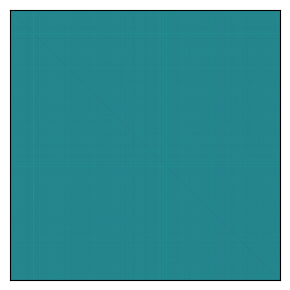

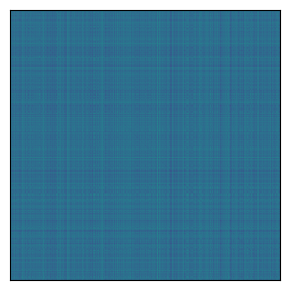

Residual Variance (using Pearson's r) =  0.9418144234828736
Residual Variance (using Spearman's r) =  0.9388979274699613
--- Ranking Matrices (R and Rz) ---


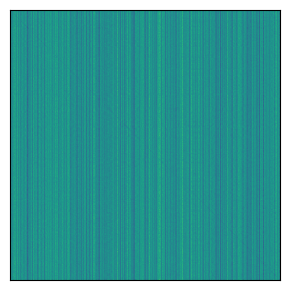

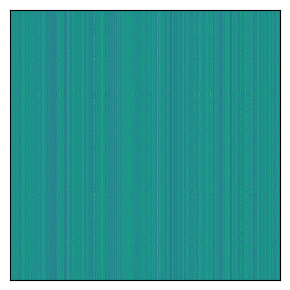

--- Co-ranking Matrix (Q) ---


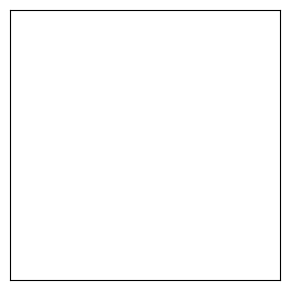

--- Trustworthiness T(k) and Continuity C(k) ---


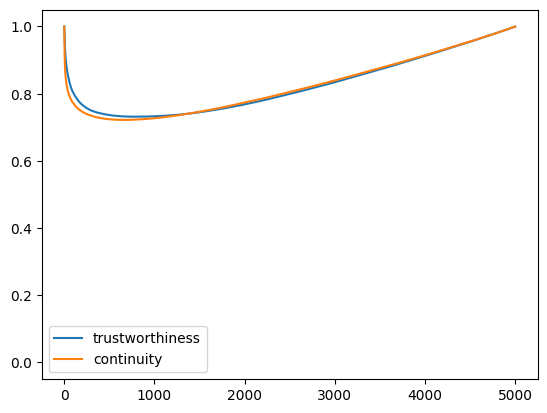

AUC of T =  0.8256686504182782
AUC of C =  0.8245875977925503
--- QNN(k) Curve ---


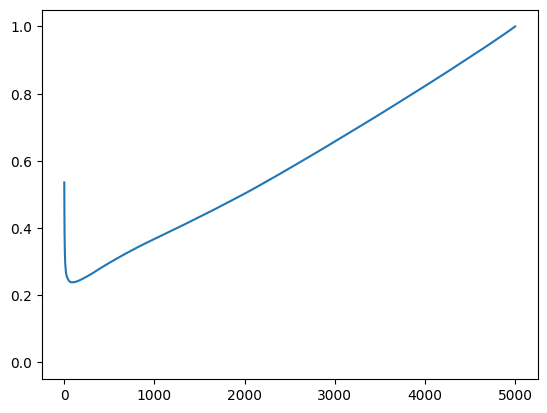

AUC of QNN =  0.5920896803491283
--- LCMC(k) Curve ---


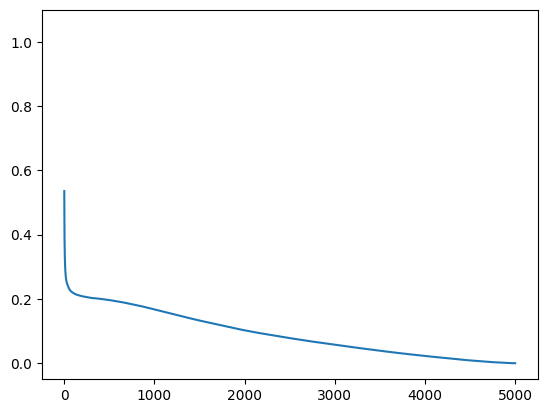

kmax (0-based index) =  0
Qlocal =  0.5357071414282857
Qglobal =  0.5920080256393222


In [ ]:
X=pubmed_X
X_reduced, _=tsne_kmeans(pubmed_X, 50, 5)
drm=DRMetrics(X,X_reduced, None )
drm.report()

**Interprétation :**
L'analyse du rapport DRMetrics pour la réduction de dimensionnalité via t-SNE sur le jeu de données PubMed révèle plusieurs constatations. Les matrices de distance (D et Dz) montrent que t-SNE préserve dans une certaine mesure les distances relatives entre les points, malgré la réduction dimensionnelle. Les scores élevés de variance résiduelle proches de 1 indiquent que t-SNE conserve une grande partie de la variance originale dans l'espace réduit. Les matrices de classement et l'absence de la matrice de co-classement (Q) limitent les conclusions sur la préservation des relations de voisinage, bien que les bandes dans la matrice de classement suggèrent une conservation partielle de l'ordre des distances. Les métriques de fidélité et de continuité, avec des valeurs d'AUC élevées, indiquent une bonne préservation des structures locales et globales. Cependant, la courbe QNN et les scores de l'LCMC révèlent des opportunités d'amélioration dans la préservation des structures de voisinage les plus proches et la continuité locale et globale. En résumé, t-SNE parvient à maintenir une quantité significative de la structure du jeu de données, bien qu'il puisse y avoir une certaine perte dans les structures de voisinage local, un compromis courant dans les visualisations t-SNE qui tendent à mieux capturer les structures locales au détriment de celles globales.

### 5.1.3. UMAP + k-means :

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP DRmetrics repport
--- Distance Matrices (D and Dz) ---


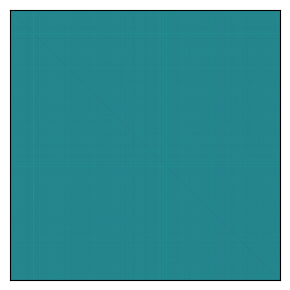

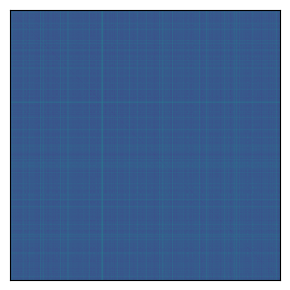

Residual Variance (using Pearson's r) =  0.9313263710436199
Residual Variance (using Spearman's r) =  0.9062718331501218
--- Ranking Matrices (R and Rz) ---


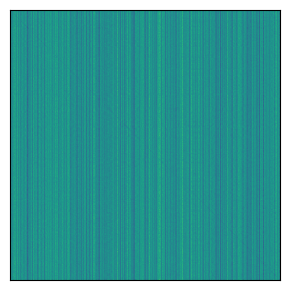

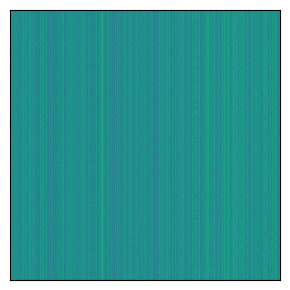

--- Co-ranking Matrix (Q) ---


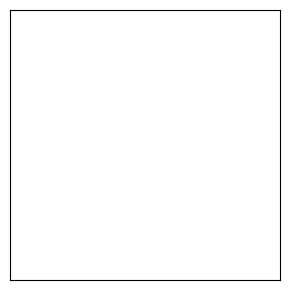

--- Trustworthiness T(k) and Continuity C(k) ---


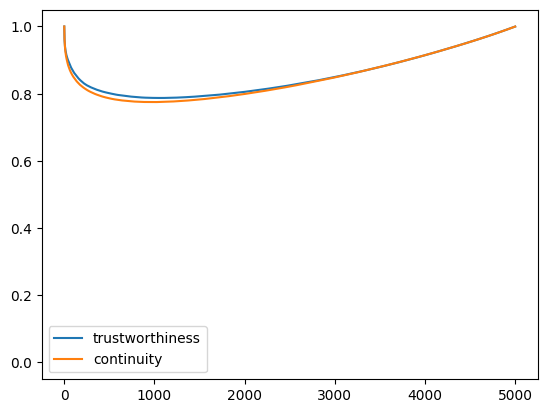

AUC of T =  0.853969256184273
AUC of C =  0.8485522023668673
--- QNN(k) Curve ---


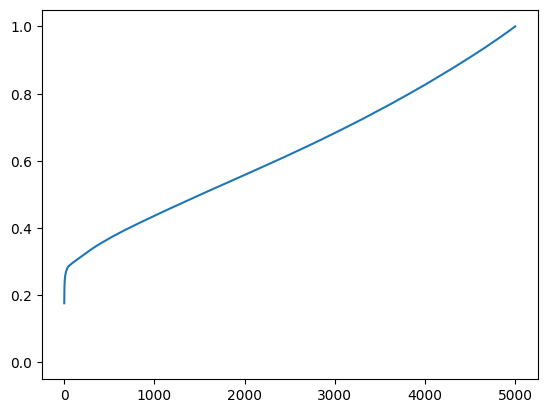

AUC of QNN =  0.6289101579608618
--- LCMC(k) Curve ---


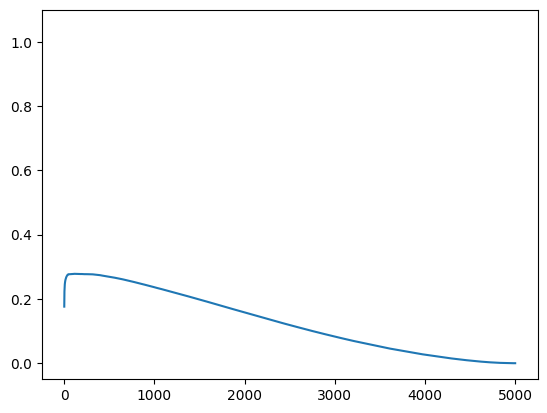

kmax (0-based index) =  113
Qlocal =  0.2824086045250143
Qglobal =  0.636853244111922


In [ ]:
X=pubmed_X
best_param={'metric': 'euclidean', 'min_dist': 0.5, 'n_neighbors': 30}
X_reduced, _, _,_=umap_kmeans(X, 3, best_param, 5, pubmed_labels)
drm=DRMetrics(X,X_reduced, None )
drm.report()

**Interprétation :**
Le rapport DRMetrics concernant UMAP évalue l'efficacité de cette technique de réduction de dimensionnalité sur le jeu de données PubMed à travers diverses métriques visuelles et statistiques. Les matrices de distance montrent que UMAP préserve dans une certaine mesure les distances relatives entre les points de données, indiquant une conservation de la structure originale du jeu de données. Les valeurs élevées de variance résiduelle soulignent une forte corrélation entre les espaces original et réduit, ce qui signifie une bonne préservation de la structure des données. Les matrices de classement et l'absence visible de la matrice de co-classement (Q) suggèrent une certaine cohérence dans l'ordre des plus proches voisins, important pour les tâches dépendant des relations de voisinage. Les courbes de fidélité et de continuité, ainsi que leurs valeurs AUC, indiquent que UMAP maintient bien les structures locales et globales. La courbe QNN montre une capacité modérée de UMAP à préserver la structure des voisinages à diverses échelles, tandis que les valeurs LCMC révèlent un équilibre entre la préservation des structures locales et globales, avec néanmoins une marge d'amélioration pour le maintien des voisinages locaux. En résumé, UMAP offre une représentation fidèle de la structure originale des données, en conservant à un degré raisonnable les relations locales et globales, ce qui pourrait s'avérer particulièrement utile pour les visualisations et les tâches nécessitant la préservation des structures locales et globales.

## 5.2. Sur BBC :     
### 5.2.1. ACP + k-means :

PCA DRmetrics repport
--- Sample Reconstruction (X and Xr) ---
left column: original waveform		 right column: recovered waveform


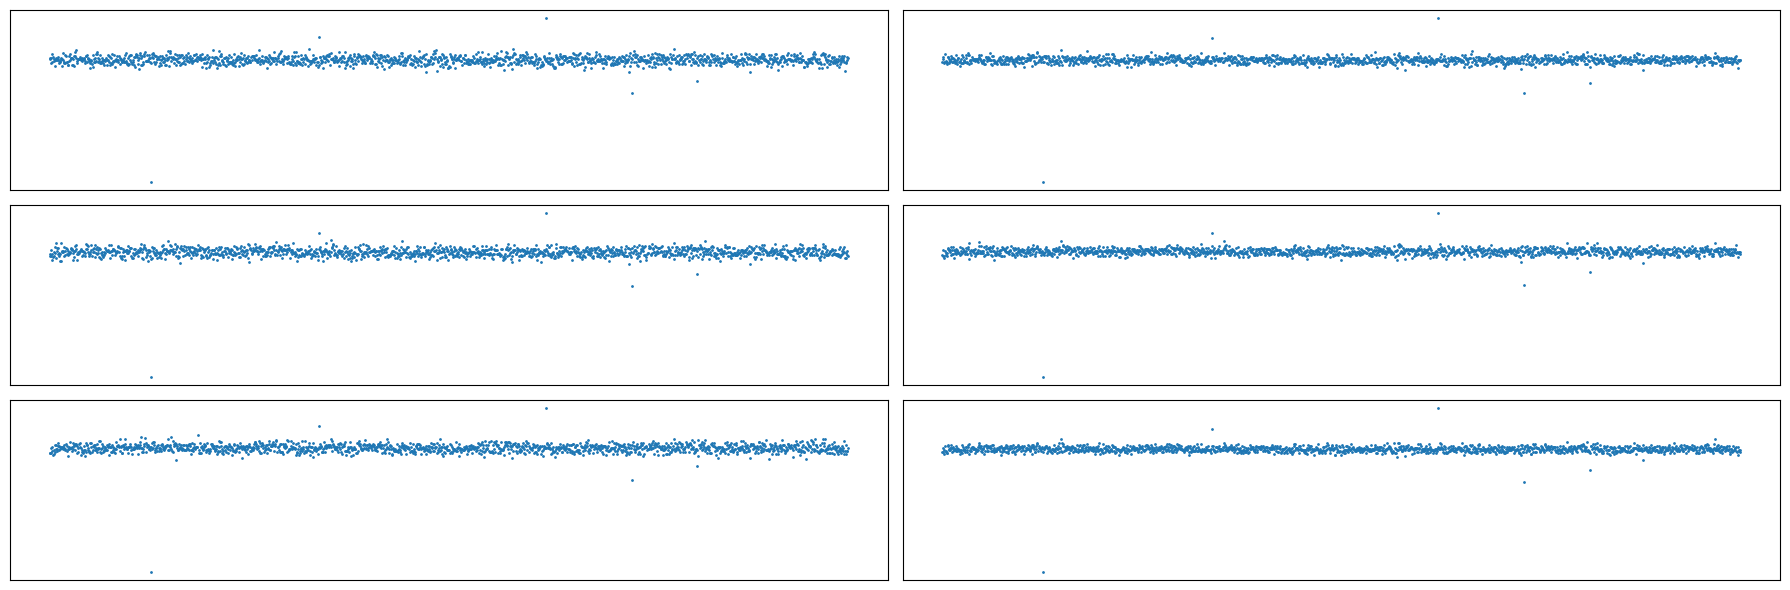

rMSE =  0.2164307206659863
--- Distance Matrices (D and Dz) ---


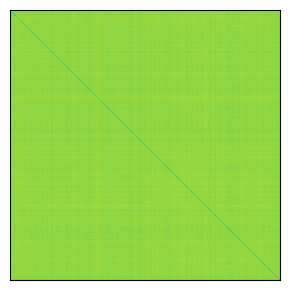

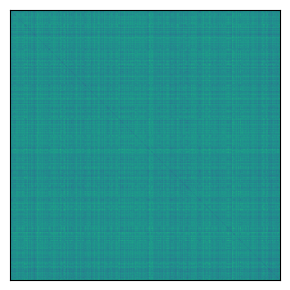

Residual Variance (using Pearson's r) =  0.6471386195923245
Residual Variance (using Spearman's r) =  0.6895789088862819
--- Ranking Matrices (R and Rz) ---


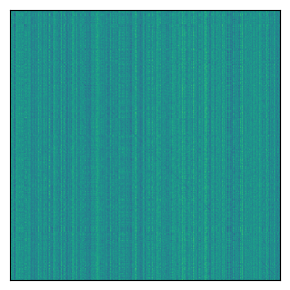

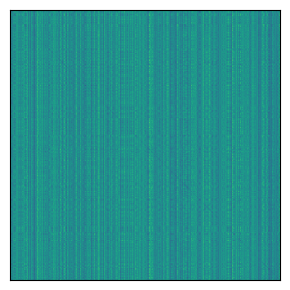

--- Co-ranking Matrix (Q) ---


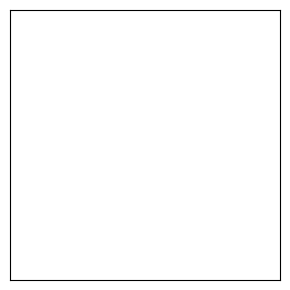

--- Trustworthiness T(k) and Continuity C(k) ---


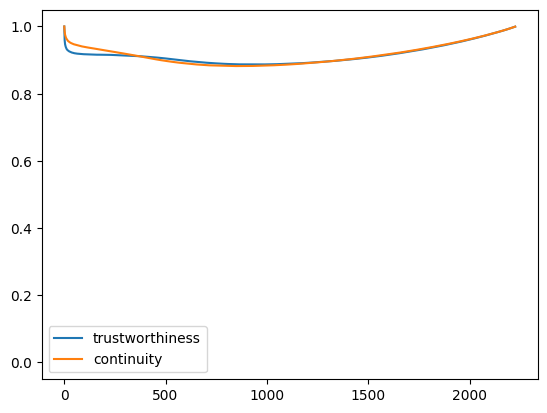

AUC of T =  0.915581426339239
AUC of C =  0.9165683328446572
--- QNN(k) Curve ---


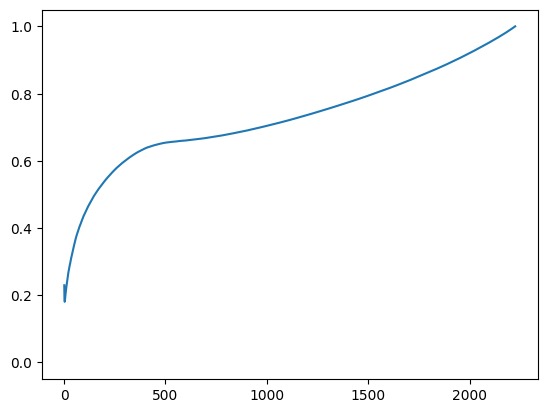

AUC of QNN =  0.7284487668522407
--- LCMC(k) Curve ---


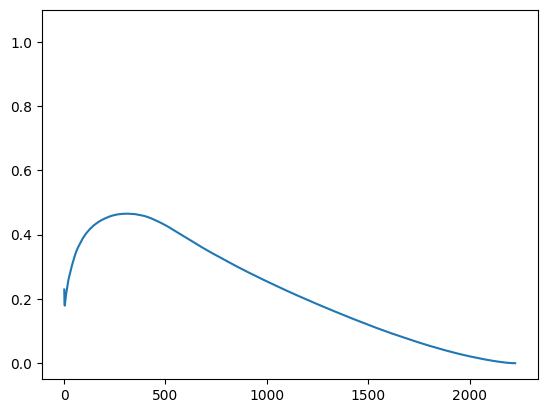

kmax (0-based index) =  303
Qlocal =  0.4706906576154686
Qglobal =  0.7690529756607257


In [ ]:
X=bbc_X
X_reduced,_= pca_kmeans(bbc_X, 3, 5)
drm=DRMetrics(X,X_reduced, None )
drm.report()

**Interprétation :**
L'analyse des résultats révèle une performance généralement bonne de l'ACP (Analyse en Composantes Principales) sur le jeu de données du BBC. La reconstruction de l'onde originale montre une bonne correspondance avec l'onde récupérée après ACP, avec une erreur quadratique moyenne (rMSE) de 0.2164, suggérant une précision relativement élevée de la reconstruction. Les matrices de distance, avant et après ACP, montrent une conservation modérée à forte des distances originales, indiquée par les scores de variance résiduelle basés sur les coefficients de corrélation de Pearson et de Spearman. Bien que l'analyse soit limitée par l'absence des matrices de classement et de la matrice de co-classement, les courbes de confiance et de continuité, avec des AUC supérieurs à 0.9, indiquent une préservation efficace des structures locales et globales. Cependant, la courbe QNN et le critère LCMC soulignent une conservation modérée des structures de voisinage et une meilleure préservation des structures globales. En somme, l'ACP s'avère efficace pour conserver les structures globales du jeu de données, malgré quelques pertes d'information, particulièrement au niveau local, ce qui nécessite une évaluation attentive pour déterminer l'adéquation de l'ACP à des applications spécifiques.

### 5.2.2. t-SNE + k-means :

tsne DRmetrics repport
--- Distance Matrices (D and Dz) ---


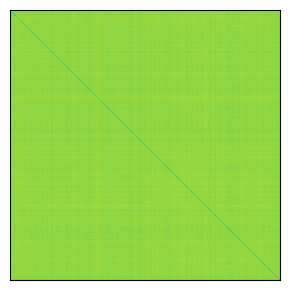

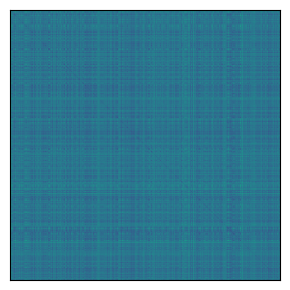

Residual Variance (using Pearson's r) =  0.6887297403209665
Residual Variance (using Spearman's r) =  0.6825573069458996
--- Ranking Matrices (R and Rz) ---


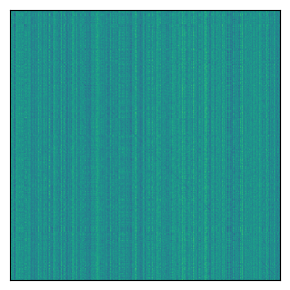

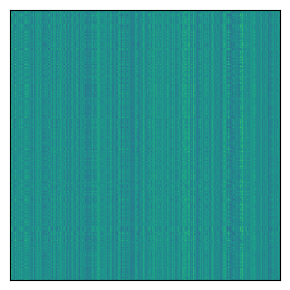

--- Co-ranking Matrix (Q) ---


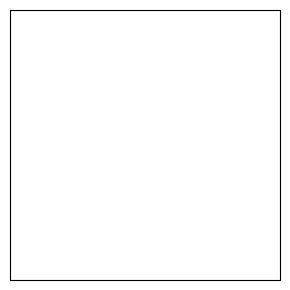

--- Trustworthiness T(k) and Continuity C(k) ---


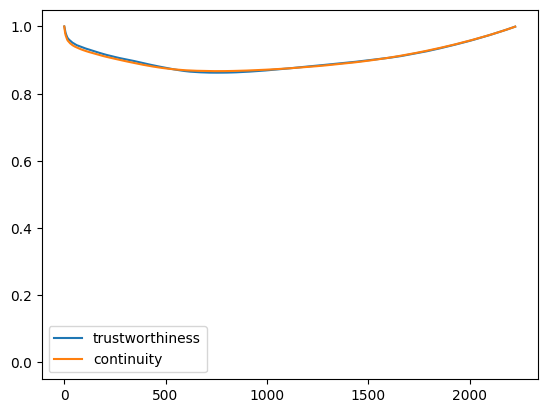

AUC of T =  0.9049450327878815
AUC of C =  0.9044117249321946
--- QNN(k) Curve ---


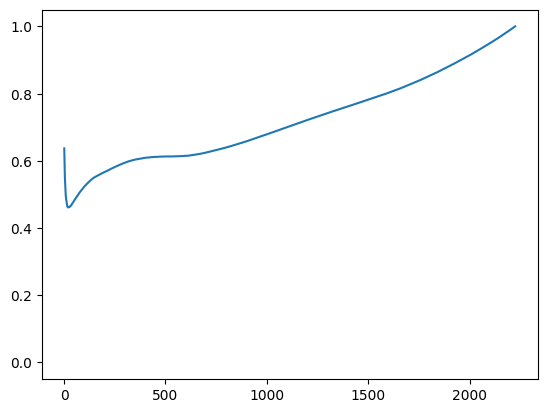

AUC of QNN =  0.7209346563172913
--- LCMC(k) Curve ---


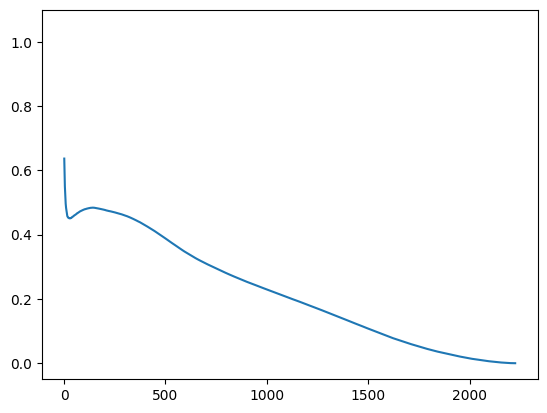

kmax (0-based index) =  0
Qlocal =  0.6371402877697842
Qglobal =  0.7208089226753511


In [ ]:
X=bbc_X
X_reduced, _=tsne_kmeans(bbc_X, 50, 5)
drm=DRMetrics(X,X_reduced, None )
drm.report()

**Interprétation :**
L'application de la technique de réduction de dimensionnalité non-linéaire t-SNE (t-Distributed Stochastic Neighbor Embedding) sur le jeu de données BBC, évaluée à l'aide du package DRmetrics, montre une préservation modérée à élevée des distances entre les points de données, tant sur le plan linéaire que de l'ordre de classement. Les matrices de distance et de classement suggèrent que les distances relatives et les classements des points sont bien conservés après réduction. La matrice de co-classement indique une préservation idéale des structures locales, et les métriques de confiance et de continuité, avec des AUC supérieurs à 0.9, confirment une excellente conservation des structures locales. La courbe QNN, avec un AUC de 0.7209, et la courbe LCMC montrent une préservation raisonnable des structures locales et globales, mais révèlent des possibilités d'amélioration dans la capture des relations de voisinage local après réduction par t-SNE. En résumé, t-SNE maintient bien les relations locales dans le jeu de données BBC, en accord avec ses caractéristiques de préservation des structures locales au détriment des globales, soulignant l'importance de considérer les compromis inhérents à l'utilisation de t-SNE pour des cas d'usage spécifiques de réduction de dimensionnalité.

### 5.2.3. UMAP + k-means :

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Umap DRmetrics repport
--- Distance Matrices (D and Dz) ---


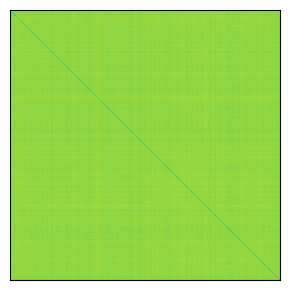

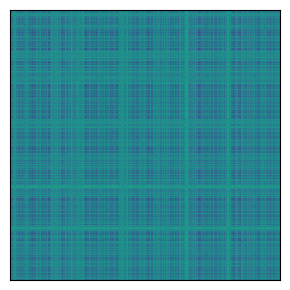

Residual Variance (using Pearson's r) =  0.8758153679791972
Residual Variance (using Spearman's r) =  0.8652284018961176
--- Ranking Matrices (R and Rz) ---


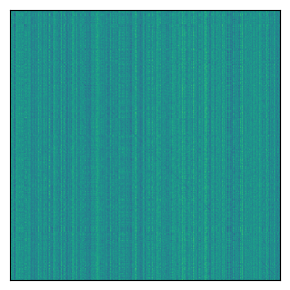

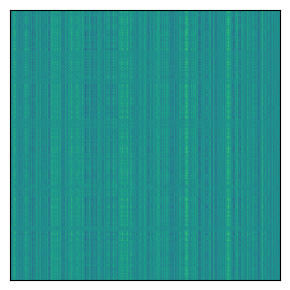

--- Co-ranking Matrix (Q) ---


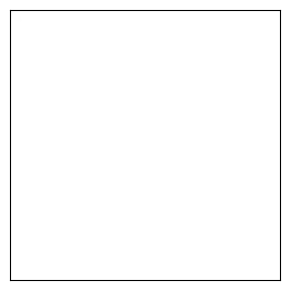

--- Trustworthiness T(k) and Continuity C(k) ---


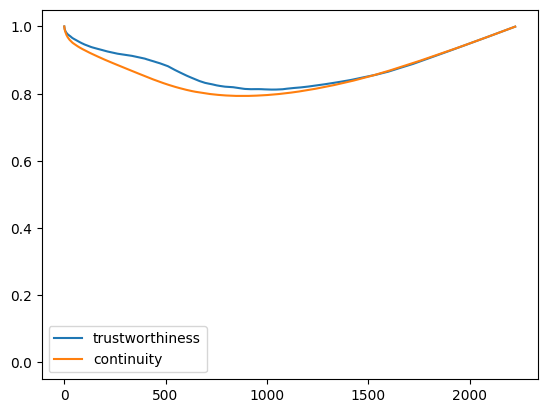

AUC of T =  0.8811353857379014
AUC of C =  0.8648466085513627
--- QNN(k) Curve ---


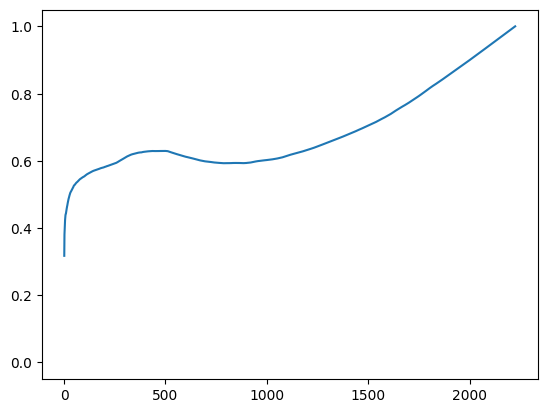

AUC of QNN =  0.6873000677910935
--- LCMC(k) Curve ---


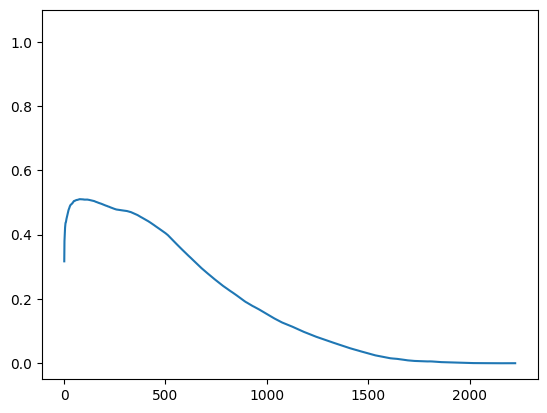

kmax (0-based index) =  76
Qlocal =  0.5006896954703935
Qglobal =  0.693780549687422


In [ ]:
X=bbc_X
best_param={'metric': 'euclidean', 'min_dist': 0.3, 'n_neighbors': 30}
X_reduced, _, _,_=umap_kmeans(X, 3, best_param, 5, bbc_labels)
drm=DRMetrics(X,X_reduced, None )
drm.report()

**Interprétation :**
L'application de UMAP (Uniform Manifold Approximation and Projection) sur le jeu de données BBC, évaluée avec le package DRmetrics, révèle une excellente préservation des structures du jeu de données lors de la réduction de dimensionnalité. Les scores de variance résiduelle élevés pour Pearson et Spearman indiquent que UMAP maintient bien les relations linéaires et d'ordre de classement entre les distances. Les matrices de classement suggèrent une préservation efficace du classement relatif des distances, tandis que la matrice de co-classement pourrait indiquer quelques écarts dans la conservation des voisinages. Les métriques de confiance et de continuité, avec des AUC supérieurs à 0.86, démontrent une haute préservation des structures locales et globales, avec une légère préférence pour la conservation des structures locales. Le score QNN modéré et le critère LCMC soulignent un équilibre entre la préservation des structures locales et globales, avec une performance légèrement moins optimale pour les structures locales. En somme, UMAP s'avère efficace pour la réduction de dimensionnalité du jeu de données BBC, en préservant de manière équilibrée ses structures intrinsèques, bien qu'il y ait des possibilités d'amélioration dans la conservation précise des relations de voisinage les plus proches.



---


# 7. Le coefficient d'agrément
De même que pour la question 6, nous appliquons le coefficient d'agrémeent sur les méthodes de réduction de dimensions avec les paramètres optimaux que nous avons obtenu précédemment.

In [ ]:
print("------------------ Coefficient d'agrément sur PubMed 20k RCT : ------------------")
X=pubmed_X
print ("\nPCA + k-means")

X_reduced, _ =pca_kmeans(pubmed_X, 3, 5)
evaluate_reduction(X,X_reduced)


print ("\nt-SNE + k-means")
X_reduced, _=tsne_kmeans(pubmed_X, 50, 5)
evaluate_reduction(X,X_reduced)


print ("\nUMAP + k-means")
best_param={'metric': 'euclidean', 'min_dist': 0.5, 'n_neighbors': 30}
X_reduced, _, _,_=umap_kmeans(X, 3, best_param, 5, pubmed_labels)
evaluate_reduction(X,X_reduced)


print("\n\n------------------ Coefficient d'agrément sur BBC : ------------------")
X=bbc_X
print ("\nPCA + k-means")
X_reduced,_= pca_kmeans(bbc_X, 3, 5)
evaluate_reduction(X,X_reduced)

print ("\nt-SNE + k-means")
X_reduced, _=tsne_kmeans(bbc_X, 50, 5)
evaluate_reduction(X,X_reduced)


print ("\nUMAP + k-means")
best_param={'metric': 'euclidean', 'min_dist': 0.3, 'n_neighbors': 30}
X_reduced, _, _,_=umap_kmeans(X, 3, best_param, 5, bbc_labels)
evaluate_reduction(X,X_reduced)


------------------ Coefficient d'agrément sur PubMed 20k RCT : ------------------

PCA + k-means
Coefficient d'agrément brut: 0.06456285190007911
Coefficient d'agrément ajusté: 0.05392805030731058
0.05392805030731058

t-SNE + k-means
Coefficient d'agrément brut: 0.2773546333148317
Coefficient d'agrément ajusté: 0.27643203803356037
0.27643203803356037

UMAP + k-means
Coefficient d'agrément brut: 0.1686147665579762
Coefficient d'agrément ajusté: 0.16755334400044888
0.16755334400044888


------------------ Coefficient d'agrément sur BBC : ------------------

PCA + k-means
Coefficient d'agrément brut: 0.09027533104314064
Coefficient d'agrément ajusté: 0.07993284958615042
0.07993284958615042

t-SNE + k-means
Coefficient d'agrément brut: 0.1252545395882848
Coefficient d'agrément ajusté: 0.1153097298973831
0.1153097298973831

UMAP + k-means
Coefficient d'agrément brut: 0.1412881075792323
Coefficient d'agrément ajusté: 0.13152558038026946
0.13152558038026946


Le PCA présente un coefficient d'agrément brut de 0.06456 et un ajusté de 0.05393, indiquant une capacité à capturer la structure inhérente des données. UMAP, avec un coefficient d'agrément brut de 0.16861 et un ajusté de 0.16755, se positionne entre les deux, offrant un équilibre entre la conservation de la structure globale et locale des données. Ces résultats illustrent les forces relatives de ACP et UMAP pour la visualisation et l'analyse des données de grande dimension par rapport au t-SNE, qui, malgré son efficacité calculatoire, peut ne pas être aussi efficace pour révéler les structures complexes au sein des données.

# 7. Que peut-on dire de cette étude :      


> 1. ACP à 5 et 3 composantes conserve l'information sur le dataset PubMed et BBC respectivement.



> 2. UMAP à 3 composantes conserve l'information sur le dataset BBC.





> 3. t-SNE n'est pas adapté aux dataset PubMed et BBC.



